### Artificial Neural Net Demonstration and Exercise

#### Goal

Reservoir property estimation from seismic information with artificial neural nets.

#### Description

Here's a simple, documented workflow, demonstration of reservoir property estimation from seismic information with artificial neural nets for subsurface modeling workflows. This should help you get started with building subsurface models that integrate machine learning to integrate data sources. 

#### Artificial Neural Networks

Machine learning method for supervised learning for classification and regression analysis.  Here are some key aspects of support vector machines.

Machine learning method for supervised learning for classification and regression analysis.  Here are some key aspects of support vector machines.

**Basic Design** *"...a computing system made up of a number of simple, highly interconnected processing elements, which process information by their dynamic state response to external inputs."* Caudill (1989). 

**Nature-inspire Computing** based on the neuronal structure in the brain, including many interconnected simple, processing units, known as nodes that are capable of complicated emergent pattern detection due to a large number of nodes and interconnectivity.

**Training and Testing** just like and other predictive model (e.g. linear regression, decision trees and support vector machines) we perform training to fit parameters and testing to tune hyperparameters.  Here we observe the error with training and testing datasets, but do not demonstrate tuning of the hyperparameters.  

**Parameters** are the weights applied to each connection and a bias term applied to each node.  For a single node in an artificial neural network, this includes the slope terms, $\beta_i$, and the bias term, $\beta_{0}$.

\begin{equation}
Y = \sum_{i=1}^m \beta_i X + \beta_0
\end{equation}

it can be seen that the number of parameters increases rapidly as we increase the number of nodes and the connectivity between the nodes.

**Layers** the typical artificial neural net is structured with an **input layer**, with one node for each $m$ predictor feature, $X_1,\ldots,X_m$. There is an **ouput layer**, with one node for each $r$ response feature, $Y_1,\ldots,Y_r$.  There may be one or more layers of nodes between the input and output layers, known as **hidden layer(s)**.  

**Connections** are the linkages between the nodes in adjacent layers.  For example, in a fully connected artificial neural network, all the input nodes are connected to all of the nodes in the first layer, then all of the nodes in the first layer are connected to the next layer and so forth. Each connection includes a weight parameter as indicated above.

**Nodes** receive the weighted signal from the connected previous layer nodes, sum and then apply this result to the **activation** function in the node. Some example activation functions include:

* **Binary** the node fires or not.  This is represented by a Heaviside step function.

* **Identify** the input is passed to the output $f(x) = x$

* **Linear** the node passes a signal that increases linearly with the weighted input.

* **Logistic** also known as sigmoid or soft step $f(x) = \frac{1}{1+e^{-x}}$

the node output is the nonlinear activiation function applied to the linearly weighted inputs. This is fed to all nodes in the next layer.

**Training Cycles** - the presentation of a batch of data, forward application of the current prediction model to make estimates, calculation of error and then backpropagation of error to correct the artificial neural network parameters to reduce the error over all of the batches.

**Batch** is the set of training data for each training cycle of forward prediction and back propagation of error, drawn to train for each iteration. There is a trade-off, a larger batch results in more computational time per iteration, but a more accurate estimate of the error to adjust the weights.  Smaller batches result in a nosier estimate of the error, but faster epochs, this results in faster learning and even possibly more robust models.

**Epochs** - is a set of training cycles, batches covering all available training data.  

**Local Minimums** - if one calculated the error hypersurface over the range of model parameters it would be hyparabolic, there is a global minimium error solution.  But this error hyper surface is rough and it is possible to be stuck in a local minimum. **Learning Rate** and **Mommentum** coefficients are introduced to avoid getting stuck in local minimums.

* **Mommentum** is a hyperparameter to control the use of information from the weight update over the last epoch for consideration in the current epoch.  This can be accomplished with an update vector, $v_i$, a mommentum parameter, $\alpha$, to calculate the current weight update, $v_{i+1}$ given the new update $\theta_{i+1}$.

\begin{equation}
v_{i+1} = \alpha v_i + \theta_{i+1}
\end{equation}

* **Learning Rate** is a hyperparameter that controls the adjustment of the weights in response to the gradient indicated by backpropagation of error 

##### Applications to subsurface modeling

We demonstrate the estimation of normal score transformed porosity from depth.  This would be useful for building a vertical trend model. 

* modeling the complicated relationship between porosity and depth.

#### Limitations of Neural Network Estimation

Since we demonstrate the use of an artificial neural network to estimate porosity from sparsely sampled data over depth, we should comment on limitations of our artificial neural networks for this estimation problem:

* does not honor the well data

* does not honor the histogram of the data

* does not honor spatial correlation 

* does not honor the multivariate relationship

* generally low interpretability models

* requires a large number of data for effective training

* high model complexity with high model variance


#### Workflow Goals

Learn the basics of machine learning in python to predict subsurface features. This includes:

* Loading and visualizing sample data
* Trying out neural nets

#### Import Required Packages

We will also need some standard packages. These should have been installed with Anaconda 3.

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import seaborn as sns                     # for plotting
import warnings                           # supress warnings from seaborn pairplot
from sklearn.model_selection import train_test_split # train / test DatFrame split

from intake import cat

We will also need the following packages to train and test our artificial neural nets:

* Tensorflow - open source machine learning 

* Keras - high level application programing interface (API) to build and train models

* This workflow was designed with tensorflow version 2.1.

To check your current version of tensorflow you could run the next block of code.

In [3]:
import tensorflow as tf
tf.__version__                            # check the installed version of tensorflow

2023-01-20 19:09:33.125483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 19:09:33.180903: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


'2.11.0'

Let's import all of the tensorflow and keras methods that we will need in our workflow.

In [4]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
import keras
from tensorflow.python.keras import backend as k

#### Loading Data 

* Depth ($m$)
* Normal Score Porosity 

It is common to transform properties to standard normal for geostatistical workflows. 

In [6]:
df2 = cat.porosity_1D.read()                                 # display first 5 samples in the table as a preview
df2.head()                                                   # we could also use this command for a table preview 

,Depth,Nporosity
0,0.25,-1.37
1,0.50,-2.08
2,0.75,-1.60
3,1.00,-1.16
4,1.25,-0.24


#### Data Normalization

We must normalize the features before we apply them in an artificial neural network model. These are the motivations for this normalization:

* remove impact of scale of different types of data (i.e., depth varies between $[0,10]$, but porosity only varies between $[-3,3.0]$).

* activation functions in artificial neural networks are designed to be more sensive to values of nodes closer to 0.0 (i.e., results in higher gradient and improves backpropagation in training)

Let's normalize each feature.  

* We apply the min max normalization by-hand to force both the predictor and response features to be bound $[-1,1]$.

* It is easy to backtransform given we keep track of the original min and max values

In [7]:
depth_min = df2['Depth'].values.min(); depth_max = df2['Depth'].values.max()
Npor_min = df2['Nporosity'].values.min(); Npor_max = df2['Nporosity'].values.max()
df2['norm_Depth'] = (df2['Depth'] - depth_min)/(depth_max - depth_min) * 2 - 1
df2['norm_Nporosity'] = (df2['Nporosity'] - Npor_min)/(Npor_max - Npor_min) * 2 - 1
df2.head()

,Depth,Nporosity,norm_Depth,norm_Nporosity
0,0.25,-1.37,-1.000000,-0.679458
1,0.50,-2.08,-0.948718,-1.000000
2,0.75,-1.60,-0.897436,-0.783296
3,1.00,-1.16,-0.846154,-0.584650
4,1.25,-0.24,-0.794872,-0.169300


It is also a good idea to check the summary statistics.  

* All normalized features should now range from -1.0 to 1.0

In [8]:
df2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Depth,40.0,5.125000,2.922613,0.25,2.687500,5.125000e+00,7.562500,10.00
Nporosity,40.0,0.024000,0.989107,-2.08,-0.757500,1.400000e-01,0.742500,2.35
norm_Depth,40.0,0.000000,0.599510,-1.00,-0.500000,-5.551115e-17,0.500000,1.00
norm_Nporosity,40.0,-0.050113,0.446549,-1.00,-0.402935,2.257336e-03,0.274266,1.00


#### Separation of Training and Testing Data

We also need to split our data into training / testing datasets so that we:

* can train our artificial neural networks using the training data 

* while testing their performance with the withheld testing (validation) data.

In [9]:
X2 = df2.iloc[:,[0,2]]                        # extract the predictor feature - acoustic impedance
y2 = df2.iloc[:,[1,3]]                        # extract the response feature - porosity
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=73073)

#### Visualize the Dataset

Let's visualize the train and test data split on a single scatter plot.

* we want to make sure it is fair

* ensure that the test samples are not clustered or too far away from the training data.

We will look at the original data and normalized data, the input to the neural network.

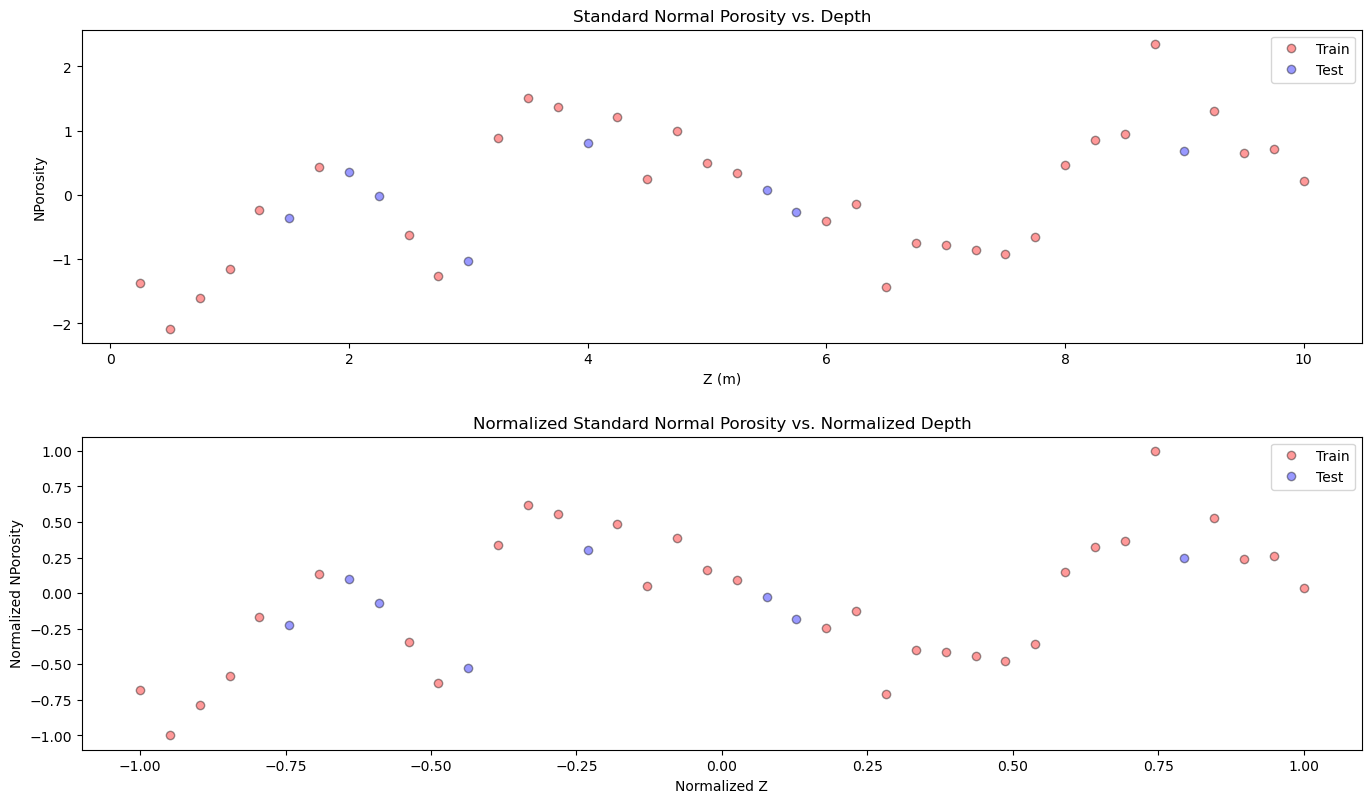

In [10]:
plt.subplot(211)
plt.plot(X2_train['Depth'].values,y2_train['Nporosity'].values, 'o', markerfacecolor='red', markeredgecolor='black', alpha=0.4, label = "Train")
plt.plot(X2_test['Depth'].values,y2_test['Nporosity'].values, 'o', markerfacecolor='blue', markeredgecolor='black', alpha=0.4, label = "Test")
plt.title('Standard Normal Porosity vs. Depth')
plt.xlabel('Z (m)')
plt.ylabel('NPorosity')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

plt.subplot(212)
plt.plot(X2_train['norm_Depth'].values,y2_train['norm_Nporosity'].values, 'o', markerfacecolor='red', markeredgecolor='black', alpha=0.4, label = "Train")
plt.plot(X2_test['norm_Depth'].values,y2_test['norm_Nporosity'].values, 'o', markerfacecolor='blue', markeredgecolor='black', alpha=0.4, label = "Test")
plt.title('Normalized Standard Normal Porosity vs. Normalized Depth')
plt.xlabel('Normalized Z')
plt.ylabel('Normalized NPorosity')
plt.legend()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.5, wspace=0.2, hspace=0.3)
plt.show()

#### Specify the Prediction Locations

Given this training and testing data, let's specify the prediction locations over the range of the observed depths at regularly spaced $nbins$ locations.  

In [11]:
# Specify the prediction locations
nbins = 1000
depth_bins = np.linspace(depth_min, depth_max, nbins) # set the bins for prediction
norm_depth_bins = (depth_bins-depth_min)/(depth_max-depth_min)*2-1 # use normalized bins

#### Build and Train a Simple Neural Network

For our first model we will build a simple model with:  

* 1 predictor feature - depth ($d$)

* 1 response feature - normal score porosity ($N\{\phi\}$)

we will build a model to predict normal score porosity from depth over all locations in our model $\bf{u} \in AOI$. 

\begin{equation}
N\{\phi(\bf{u})\} = \hat{f} (d(\bf{u}))
\end{equation}

and use this model to support the prediction of porosity between the wells.

#### Design, Train and Test a Neural Network

In the following code we use keras / tensorflow to:

1. **Design the Network** - we use a fully connected, feed forward neural network with one node in the input and output layers, to receive the normalized depth and output the normalized (normal score) porosity.  We found by trial and error, given the complexity of the dataset, that we required a significant network width (about 500 nodes) and a network depth of atleast 4 hidden layers. 


2. **Select the Optimizer** - we selected the adam optimizer (Kingma and Ba, 2015).  This optimizer is computationally efficient and is well suited to problems with noisy data and sparse gradients. It is an extension of stochastic gradient descent with the addition of adaptive gradient algorithm that calculates per-parameter learning rates to improve learning with sparse gradients, and root mean square propopagation that sets the learning rate based on the recent magnitudes of the gradients for each parameter to improve performance with noisy data.  We include stochastic gradient descent for experimentation. 

    * we found a learning rate of 0.01 to 0.001 works well
    * we found the rate of decay parameters of $\beta_1=0.9$ and $\beta_2=0.999$ performed well
    

3. **Compile the Machine** - specify the optimizer, loss function and the metric for model training. 


4. **Train the Network** - fit / train the model parameters over a specified number of batch size within a specified number of epochs.  We specify the train and test normalized predictor and response features.

Then we visualize the model in the original units.

32/32 [==============================] - 0s 560us/step


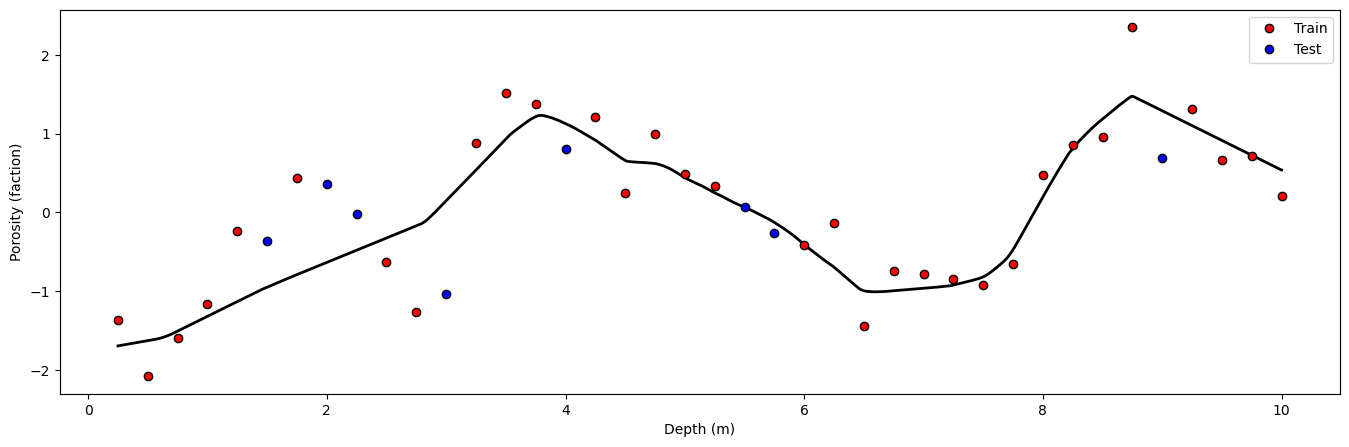

In [17]:
# Design the neural network
model_2 = Sequential([
    Dense(1, activation='linear', input_shape=(1,)),                  # input layer
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'), 
    Dense(100, activation='relu'),                                    # uncomment these to add hidden layers
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(1, activation='linear'),                                     # output layer
])

# Select the Optimizer
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0, amsgrad=False) # adam optimizer
#sgd = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay = 0.0, nesterov=False)  # stochastic gradient descent

# Compile the Machine
model_2.compile(optimizer=adam,loss='mse',metrics=['accuracy'])

# Train the Network
hist_2 = model_2.fit(X2_train['norm_Depth'], y2_train['norm_Nporosity'],
    batch_size=5, epochs=1000,
    validation_data=(X2_test['norm_Depth'], y2_test['norm_Nporosity']),verbose = 0)

# Predict with the Network
pred_norm_Nporsity = model_2.predict(np.array(norm_depth_bins)) # predict with our ANN
pred_Nporosity = ((pred_norm_Nporsity + 1)/2*(Npor_max - Npor_min)+Npor_min)

# Plot the Model Predictions
plt.subplot(1,1,1)
plt.plot(depth_bins,pred_Nporosity,'black',linewidth=2)
plt.plot(X2_train['Depth'].values,y2_train['Nporosity'].values, 'o', markerfacecolor='red', markeredgecolor='black', alpha=1.0, label = "Train")
plt.plot(X2_test['Depth'].values,y2_test['Nporosity'].values, 'o', markerfacecolor='blue', markeredgecolor='black', alpha=1.0, label = "Test")
plt.xlabel('Depth (m)')
plt.ylabel('Porosity (faction)')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

#### Evaluation of the Model

For my specified artificial neural network design and optimization parameters I have a very flexible model to fit the data.

* artificial neural networks live up to their designation as **Universal Function Approximators**

Let's check the training curve, loss functions for our model over training and testing datasets.

* **square loss** ($L_2$ loss) is the:

\begin{equation}
L_2 = \sum_{\bf{u}_{\alpha} \in AOI} \left(y(\bf{u}_{\alpha}) - \hat{f}(x_1(\bf{u}_{\alpha}),\ldots,x_m(\bf{u}_{\alpha})\right)
\end{equation}

* this is a measure of the inaccuracy over the available data

We can see the progress of the model over epochs in reduction of training and testing error.

* we can observe that the model matches the training data after about 200 epochs, but continues to improve up the 1,000 epochs

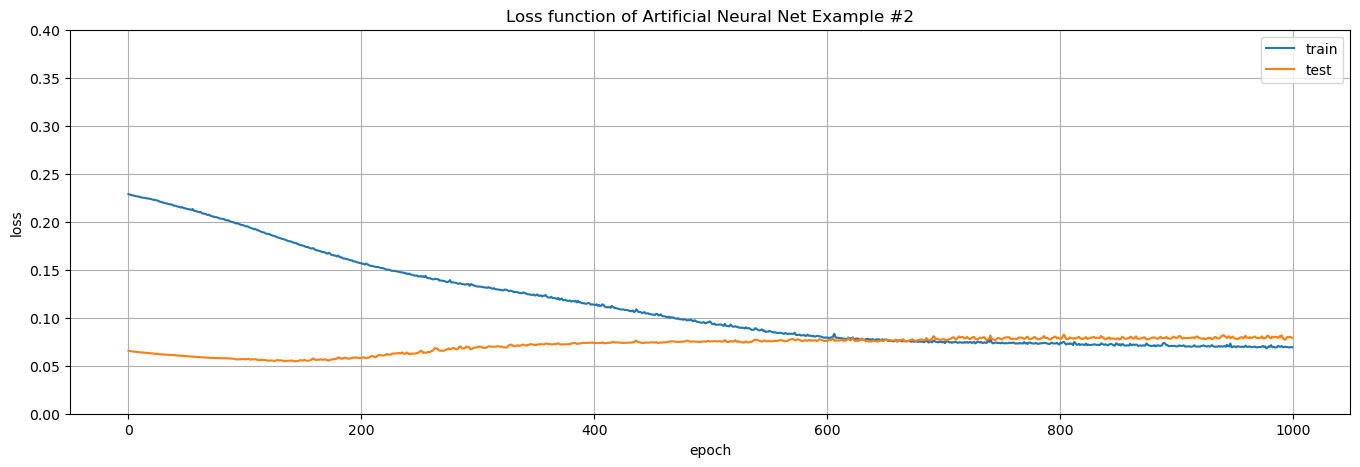

In [14]:
# Plot the Loss vs. Training Epoch 
plt.subplot(1,1,1)
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('Loss function of Artificial Neural Net Example #2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0,0.4)
plt.grid()
plt.tight_layout()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

#### Some Observations

We performed a set of experiments and made the following observations that may help you experiment with the design and training of this artificial neural network. Each machine was trained over 1000 epochs with a batch size of 5.
 
For a 1 $\times$ 100 $\times$ 100 $\times$ 1 neural network:
* Learning Rate of 0.001 still converging at 1000 epochs, missing some features
* Learning Rate of 0.1 - stuck in a local minum as a step function

For a 1 $\times$ 500 $\times$ 500 $\times$ 1 neural network:
* Learning Rate of 0.01 - 0.001 for a close fit to training data
* Learning Rate of 0.1 - stuck in a local minimum as a line
* Learning Rate of $\le$ 0.0001 still converging at 1000 epochs, missing some features

For a 1 $\times$ 500 $\times$ 500 $\times$ 500 $\times$ 1 neural network:
* Learning Rate of 0.01 - 0.001 for a close fit to training data
* Learning Rate of 0.1 - stuck as a line
* Learning Rate of $\le$ 0.0001 still converging at 1000 epochs, missing some features

#### Visualizing the Neural Net

There are some methods available to interogate the artificial neural net.

* neural net summary

* weights

Here's the summary from our neural net.  It lists by layers the number of nodes and number of parameters.

In [15]:
model_2.summary()                                      # artificial neural network design and number of parameters

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
 dense_6 (Dense)             (None, 50)                100       
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,253
Trainable params: 5,253
Non-trainable params: 0
_________________________________________________________________


We can also see the actual trained weights for each node in each layer.

In [16]:
for layer in model_2.layers:                            # weights for the trained artificial neural network
    g = layer.get_config()
    h = layer.get_weights()
    print(g)
    print(h)
    print('\n')

{'name': 'dense_5', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 1), 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[-0.7087793]], dtype=float32), array([-0.05800613], dtype=float32)]


{'name': 'dense_6', 'trainable': True, 'dtype': 'float32', 'units': 50, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[ 1.76874176e-01, -7.26896301e-02,  3.20839018e-01,
        -4.14385885e-01,  2.28786945e-01, -5.24915457

We can observe the weights and bias terms associate with our neural network.